In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\15126\AppData\Local\Temp\ipykernel_3172\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date

'2017-08-23'

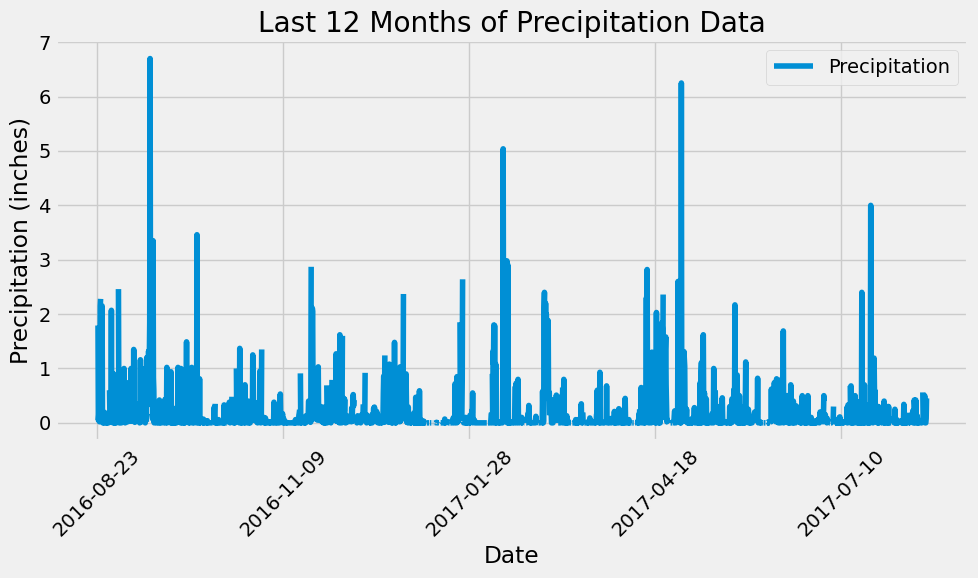

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the last date in the dataset
most_recent_date = session.query(func.max(measurement.date)).scalar()
one_year_ago = (dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=["Date", "Precipitation"])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x="Date", y="Precipitation", figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Last 12 Months of Precipitation Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df["Precipitation"].describe()
summary_statistics

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()

# Print the total number of stations
total_stations


9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(measurement.station, func.count(measurement.station).label("count")).\
    group_by(measurement.station).\
    order_by(desc("count")).all()

# Create a DataFrame to display the results
most_active_stations_df = pd.DataFrame(station_counts, columns=["Station", "Observation Count"])

# Display the stations and their counts in descending order
most_active_stations_df

,Station,Observation Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs).label("Lowest Temperature"),
                                 func.max(measurement.tobs).label("Highest Temperature"),
                                 func.avg(measurement.tobs).label("Average Temperature")).\
    filter(measurement.station == most_active_station).all()

# Create a DataFrame to display the temperature statistics
temperature_stats_df = pd.DataFrame(temperature_stats)

# Display the lowest, highest, and average temperature for the most active station
temperature_stats_df

,Lowest Temperature,Highest Temperature,Average Temperature
0,54.0,85.0,71.663781


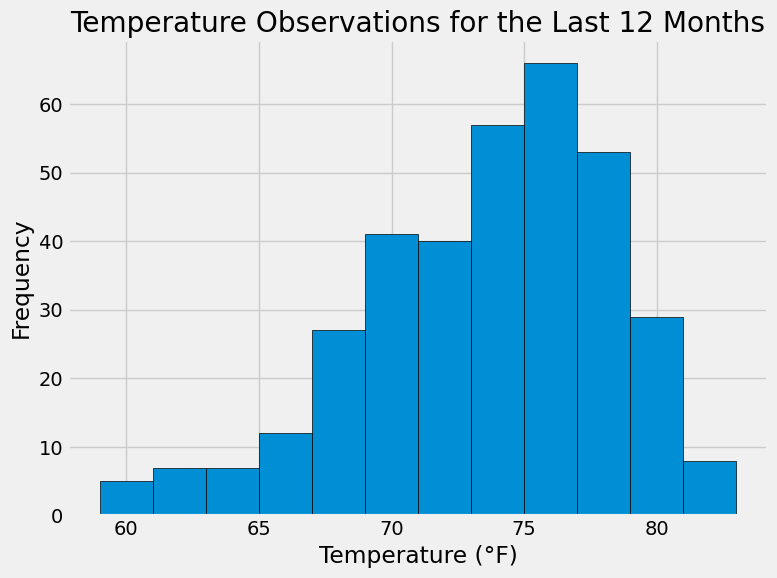

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Get the most active station (first station in the previous result)
most_active_station = station_counts[0][0]

# Design a query to retrieve the last 12 months of temperature observation data for the most active station
temperature_data = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= one_year_ago).all()

# Extract the temperature values from the query result
temperatures = [result[0] for result in temperature_data]

# Create a histogram plot
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title("Temperature Observations for the Last 12 Months")
plt.grid(True)
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()